# 09 Classify videos by joke type and visualise with FiftyOne

Each video demonstrates a single joke type. We have this as meta-data. Can we train a classifier based on the movement data?

Each video shows one joke from a set of five possibilities [Peekaboo,TearingPaper,NomNomNom,ThatsNotAHat,ThatsNotACat].

We will use TensorFlow to train a classifier to predict the joke type from the movement data.
In order to see what classifier is doing, we will use [FiftyOne]() to visualise the data and predictions

In [1]:
import os
import fiftyone as fo
import pandas as pd
import numpy as np

# Make numpy values easier to read.
np.set_printoptions(precision=4, suppress=True)

import tensorflow as tf
from tensorflow.keras import layers

# local imports
import utils
import display
import calcs

## 9.1 Load the data

### Use either small demo 
Consists of 54 videos. From 4 families (parent and baby) demoing five jokes three times each. (Some missing)

In [2]:
videos_in = os.path.join("..","LookitLaughter.test")
demo_data = os.path.join("..","data", "demo")
temp_out = os.path.join("..","data","0_temp")
data_out = os.path.join("..","data","1_interim")
videos_out = os.path.join("..","data","2_final")

### Or the Full set

Consists of 1425 videos. From 90 familes (parent and baby) demoing approximately five jokes three times each. Some repetitions and omissions.

In [3]:
videos_in = os.path.join("..","..","LookitLaughter.full.videos")
temp_out = os.path.join("..","..","LookitLaughter.full.data","0_temp")
data_out = os.path.join("..","..","LookitLaughter.full.data","1_interim")
videos_out = os.path.join("..","..","LookitLaughter.full.data","2_final")


In [4]:
processedVideos = utils.getProcessedVideos(data_out)
minFrames = processedVideos['Frames'].min()
maxFrames = processedVideos['Frames'].max()
print(f"We have {len(processedVideos)} processed videos.")
print(f"Min Frames: {minFrames}\nMax Frames: {maxFrames}")
processedVideos.head()

Found existing processedvideos.xlsx with 1412 rows.
We have 1412 processed videos.
Min Frames: 3
Max Frames: 2696


,VideoID,ChildID,JokeType,Joke.Label,JokeNum,JokeRep,JokeTake,HowFunny,HowFunny.Value,LaughYesNo,...,Audio.when,Audio.file,Faces.when,Faces.file,Speech.when,Speech.file,LastError,annotatedVideo,annotated.when,Keypoints.normed
0,NFCK3A.joke1.rep1.take1.ThatsNotAHat.mp4,NFCK3A,ThatsNotAHat,5,1,1,1,Slightly funny,2,No,...,2024-02-16 19:04:52,..\..\LookitLaughter.full.data\1_interim\NFCK3...,NaN,NaN,2024-02-16 19:28:34,..\..\LookitLaughter.full.data\1_interimNFCK3A...,NaN,NaN,NaN,..\..\LookitLaughter.full.data\1_interim\NFCK3...
1,NFCK3A.joke1.rep1.take2.ThatsNotAHat.mp4,NFCK3A,ThatsNotAHat,5,1,1,2,Slightly funny,2,No,...,2024-02-16 19:04:52,..\..\LookitLaughter.full.data\1_interim\NFCK3...,NaN,NaN,2024-02-16 19:28:35,..\..\LookitLaughter.full.data\1_interimNFCK3A...,NaN,NaN,NaN,..\..\LookitLaughter.full.data\1_interim\NFCK3...
2,NFCK3A.joke1.rep2.take1.ThatsNotAHat.mp4,NFCK3A,ThatsNotAHat,5,1,2,1,Not funny,1,No,...,2024-02-16 19:04:53,..\..\LookitLaughter.full.data\1_interim\NFCK3...,NaN,NaN,2024-02-16 19:28:36,..\..\LookitLaughter.full.data\1_interimNFCK3A...,NaN,NaN,NaN,..\..\LookitLaughter.full.data\1_interim\NFCK3...
3,NFCK3A.joke1.rep3.take1.ThatsNotAHat.mp4,NFCK3A,ThatsNotAHat,5,1,3,1,Not funny,1,No,...,2024-02-16 19:04:53,..\..\LookitLaughter.full.data\1_interim\NFCK3...,NaN,NaN,2024-02-16 19:28:36,..\..\LookitLaughter.full.data\1_interimNFCK3A...,NaN,NaN,NaN,..\..\LookitLaughter.full.data\1_interim\NFCK3...
4,NFCK3A.joke2.rep1.take1.TearingPaper.mp4,NFCK3A,TearingPaper,3,2,1,1,Not funny,1,No,...,2024-02-16 19:04:53,..\..\LookitLaughter.full.data\1_interim\NFCK3...,NaN,NaN,2024-02-16 19:28:37,..\..\LookitLaughter.full.data\1_interimNFCK3A...,NaN,NaN,NaN,..\..\LookitLaughter.full.data\1_interim\NFCK3...


(array([         17,         123,         219,         287,         264,         170,         109,          59,          52,          33,          23,          16,           9,          10,           4,           3,           3,           3,           1,           0,           0,           1,           1,           0,
                  0,           0,           0,           1,           0,           1,           0,           0,           0,           0,           0,           0,           0,           0,           0,           3]),
 array([          3,      70.325,      137.65,      204.98,       272.3,      339.62,      406.95,      474.28,       541.6,      608.93,      676.25,      743.58,       810.9,      878.23,      945.55,      1012.9,      1080.2,      1147.5,      1214.9,      1282.2,      1349.5,      1416.8,      1484.2,      1551.5,
             1618.8,      1686.1,      1753.5,      1820.8,      1888.1,      1955.4,      2022.8,      2090.1,      2157.4,      2224.7,     

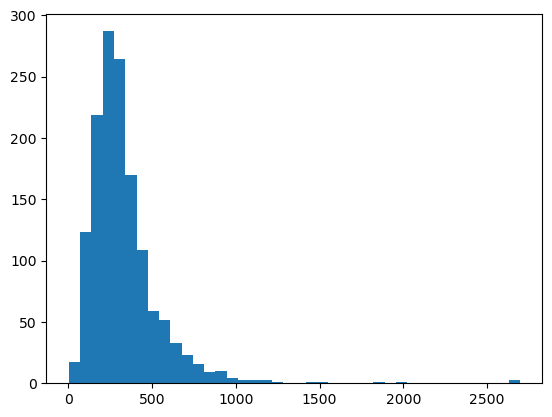

In [5]:
# use matplotlib to draw histograam of number of frames

import matplotlib.pyplot as plt

plt.hist(processedVideos['Frames'], bins=40)

# 9.2 Use Voxel51 and PytorchVideo for examining videos

Voxel51 seems to be a useful tool for looking at training data (and trained predictions).

Let's start with the minimal implementation. Just viewing videos.

https://docs.voxel51.com/user_guide/dataset_creation/index.html



### 9.2.1 Is dataset already created?

FiftyOne may aleady have a dataset created. Let's check. And reload it. 

In [6]:
datasets = fo.list_datasets()
if len(datasets) == 0:
    print("No datasets found. Load in step 7.1.2")
else:
    print("Loading saved datasets: ", datasets[0])
    dataset = fo.load_dataset(datasets[0])

Loading saved datasets:  2024.06.29.18.16.36


### 7.1.2 Populate a FiftyOne dataset with our videos and labels.

Either there is no existing dataset or we want to rebuild it.

In [7]:
# optional: delete datasets
fo.delete_datasets("*")

In [8]:
# Create a dataset from a directory of videos
dataset = fo.Dataset.from_videos_dir(videos_in)
dataset.ensure_frames()

dataset.name = 'LookitLaughter.full'

dataset.add_sample_field("JokeType", fo.StringField, description="What joke is being told?")
dataset.add_sample_field("HowFunny", fo.StringField, description="How funny is the joke?")
dataset.add_sample_field("LaughYesNo",  fo.BooleanField, description="Did the child laugh?")

 100% |███████████████| 1425/1425 [168.0ms elapsed, 0s remaining, 8.5K samples/s]     
Computing metadata...
 100% |███████████████| 1425/1425 [58.1s elapsed, 0s remaining, 25.6 samples/s]      


Now let's see if we can add our metadata classifications. Recalling that each video demos one joke type `[Peekaboo,TearingPaper,NomNomNom,ThatsNotAHat,ThatsNotACat]` and has rating of how funny the baby found it `[Not Funny, Slightly Funny, Funny, Extremely Funny]` and whether they laughed `[Yes, No]`.


In [9]:
# add the joke type, how funny and laugh yes/no for each sample in the dataset
for sample in dataset:
    #split the filepath to get the video name, system independent
    videoname = os.path.basename(sample.filepath)
    row = processedVideos[processedVideos["VideoID"]==videoname]
    if len(row) == 0:
        print(f"Video {videoname} not found in processed videos.")
        continue
    sample["VideoID"]  = row["VideoID"].values[0]
    sample["JokeType"]  = row["JokeType"].values[0]
    sample["HowFunny"]  = row["HowFunny"].values[0]
    sample["LaughYesNo"]  = (row["LaughYesNo"].values[0] == "Yes")
#    sample["JokeType"]  = fo.Classification(label = row["JokeType"].values[0])
#    sample["HowFunny"]  = fo.Classification(label = row["HowFunny"].values[0])
#    sample["LaughYesNo"]  = fo.Classification(label = (row["LaughYesNo"].values[0] == "Yes"))
    
    sample.save()

Video cJ3K55.joke1.rep1.take1.TearingPaper.mp4 not found in processed videos.
Video cJ3K55.joke1.rep2.take1.TearingPaper.mp4 not found in processed videos.
Video cJ3K55.joke1.rep3.take1.TearingPaper.mp4 not found in processed videos.
Video cJ3K55.joke2.rep1.take1.NomNomNom.mp4 not found in processed videos.
Video cJ3K55.joke2.rep2.take1.NomNomNom.mp4 not found in processed videos.
Video cJ3K55.joke2.rep3.take1.NomNomNom.mp4 not found in processed videos.
Video cJ3K55.joke3.rep2.take1.Peekaboo.mp4 not found in processed videos.
Video cJ3K55.joke3.rep3.take1.Peekaboo.mp4 not found in processed videos.
Video cJ3K55.joke4.rep2.take1.ThatsNotACat.mp4 not found in processed videos.
Video cJ3K55.joke4.rep3.take1.ThatsNotACat.mp4 not found in processed videos.
Video cJ3K55.joke5.rep1.take1.ThatsNotAHat.mp4 not found in processed videos.
Video cJ3K55.joke5.rep2.take1.ThatsNotAHat.mp4 not found in processed videos.
Video cJ3K55.joke5.rep3.take1.ThatsNotAHat.mp4 not found in processed videos.


Let's add the frame by frame annotations directly onto the videos inside fiftyone

In [10]:
#Let's start with people bounding boxes

for sample in dataset:
    #retrieve people bounding boxes from the keypoints file
    try:
        keypoints = utils.readKeyPointsFromCSV(processedVideos,sample.filepath,normed= True)    
    except FileNotFoundError as e:
        print(f"Error reading keypoints for {sample.filepath}")
        continue
    
    for index, row in keypoints.iterrows():
        framenumber = row["frame"] + 1
        person = row["person"]
        bbox = [row["bbox.x1"], row["bbox.y1"], row["bbox.x2"], row["bbox.y2"]]
        bbox51 = calcs.xyxy2ltwh(bbox)
        if sample.frames[framenumber]:
            frame = sample.frames[framenumber]
        else:
            frame = fo.Frame()
        frame[person] = fo.Detection(label=person, bounding_box=bbox51)
        sample.frames[framenumber] = frame
        #TODO fiftyone add keypoints not well documented and i can't get it to work. 
        #frame[person + "KeyPoints"] =  
        #fo.KeypointSkeleton()
        #TODO can't see how to add timesynced captions either!

        sample.save()
        
dataset.save()

Error reading keypoints for C:\Users\caspar\OneDrive\LegoGPI\LookitLaughter.full.videos\cJ3K55.joke1.rep1.take1.TearingPaper.mp4
Error reading keypoints for C:\Users\caspar\OneDrive\LegoGPI\LookitLaughter.full.videos\cJ3K55.joke1.rep2.take1.TearingPaper.mp4
Error reading keypoints for C:\Users\caspar\OneDrive\LegoGPI\LookitLaughter.full.videos\cJ3K55.joke1.rep3.take1.TearingPaper.mp4
Error reading keypoints for C:\Users\caspar\OneDrive\LegoGPI\LookitLaughter.full.videos\cJ3K55.joke2.rep1.take1.NomNomNom.mp4
Error reading keypoints for C:\Users\caspar\OneDrive\LegoGPI\LookitLaughter.full.videos\cJ3K55.joke2.rep2.take1.NomNomNom.mp4
Error reading keypoints for C:\Users\caspar\OneDrive\LegoGPI\LookitLaughter.full.videos\cJ3K55.joke2.rep3.take1.NomNomNom.mp4
Error reading keypoints for C:\Users\caspar\OneDrive\LegoGPI\LookitLaughter.full.videos\cJ3K55.joke3.rep2.take1.Peekaboo.mp4
Error reading keypoints for C:\Users\caspar\OneDrive\LegoGPI\LookitLaughter.full.videos\cJ3K55.joke3.rep3.take

In [11]:
session = fo.launch_app(dataset)
# in docker launch fiftiy needs port
# session = fo.launch_app(dataset, address="0.0.0.0", port=5151)

## 9.3 Load and preprocess the data

1. Load normed movement data. 
2. Exclude videos shorter than a min length
3. Pad all sequences to the same max length. 
4. Interpolate missing values (up to last frame of real data).
5. Replace final missing values with zeros.
6. Add to tf.data.Dataset.

In [ ]:
def createMovementDataset(processedVideos, minFrames = 0, maxFrames = None, ragged = False):
    """
    Creates a movement dataset from processed videos.

    Args:
        processedVideos (pandas.DataFrame): A DataFrame containing processed video data.
        minFrames (int, optional): Rows with less than minframes are excluded. Defaults to 0 (include all frames.)
        maxFrames (int, optional): Data padded or truncated to have maxFrames. Defaults to max of all videos.
        ragged (bool, optional): Whether to create a ragged tensor. Defaults to False (TODO: not implemented yet)

    Returns:
        tf.data.Dataset: A TensorFlow Dataset containing features and labels.
    """
    if maxFrames is None:
        maxFrames = processedVideos["Frames"].max()
    if ragged:
        raise NotImplementedError("Ragged tensors not implemented yet.")    
    dataset = []
    labels = []
    # for each row of processedVideos, we add one timeseries to the dataset
    for index, r in processedVideos.iterrows():
        df = pd.read_csv(r['Keypoints.normed'])
        if r["Frames"] < minFrames:
            continue
        df = utils.padMovementData(df, maxFrames)
        df = utils.interpolateMovementData(df)
        df = df.replace(np.nan, 0)
        df = utils.flattenMovementDataset(df)
        
        features = tf.convert_to_tensor(df.values, dtype=tf.float32)
        label = r["Joke.Label"]
        dataset.append(features)
        labels.append(label)
    
    return tf.data.Dataset.from_tensor_slices((dataset, labels))

In [ ]:
trainMinFrames = 100
trainMaxFrames = 1000   
tfdataset = createMovementDataset(processedVideos,trainMinFrames,trainMaxFrames)

train, test = tf.keras.utils.split_dataset(tfdataset, left_size=0.8)

In [ ]:
#get first element of dataset so we can grab its dimensions
keyPoints = next(iter(train))[0]

#let's build a simple model
model = tf.keras.Sequential([
    layers.Input(shape=(keyPoints.shape[0], keyPoints.shape[1])),
    layers.LSTM(8),
    layers.Dense(1)
])

# Compile the model
model.compile(loss=tf.losses.MeanSquaredError(),
              sample_weight_mode='temporal',
              optimizer=tf.optimizers.Adam(),
              metrics=[tf.metrics.MeanAbsoluteError()])

# Train the model
model.fit(train.batch(32), epochs=20)


In [ ]:
#let's evaluate the model
model.evaluate(test.batch(32))

#table of predictions
predictions = model.predict(test.batch(32))

In [ ]:
predictions

In [ ]:
labels